This lab on Ridge Regression and the Lasso is a Python adaptation of p. 251-255 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Adapted by R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016).

# 6.6: Ridge Regression and the Lasso

In [0]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.datasets import load_boston

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

We will use the `sklearn` package in order to perform ridge regression and
the lasso. The main functions in this package that we care about are `Ridge()`, which can be used
to fit ridge regression models, and `Lasso()` which will fit lasso models. They also have cross-validated counterparts: `RidgeCV()` and `LassoCV()`. We'll use these a bit later.

Before proceeding, let's first ensure that the missing values have
been removed from the data, as described in the previous lab.

In [48]:
boston_data = load_boston()
df = pd.DataFrame(boston_data.data,columns=boston_data.feature_names)
df['MEDV'] = pd.Series(boston_data.target)
df.head()

CRIM    ZN  INDUS  CHAS    NOX  ...    TAX  PTRATIO       B  LSTAT  MEDV
0  0.00632  18.0   2.31   0.0  0.538  ...  296.0     15.3  396.90   4.98  24.0
1  0.02731   0.0   7.07   0.0  0.469  ...  242.0     17.8  396.90   9.14  21.6
2  0.02729   0.0   7.07   0.0  0.469  ...  242.0     17.8  392.83   4.03  34.7
3  0.03237   0.0   2.18   0.0  0.458  ...  222.0     18.7  394.63   2.94  33.4
4  0.06905   0.0   2.18   0.0  0.458  ...  222.0     18.7  396.90   5.33  36.2

[5 rows x 14 columns]

We will now perform ridge regression and the lasso in order to predict `Salary` on
the `Hitters` data. Let's set up our data:

In [49]:
y = df.MEDV 
#y = df['MEDV']

X = df.drop(['MEDV'], axis=1)

X.info()
#y

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


# 6.6.1 Ridge Regression
The `Ridge()` function has an alpha argument ($\lambda$, but with a different name!) that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially
covering the full range of scenarios from the null model containing
only the intercept, to the least squares fit:

In [50]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

Associated with each alpha value is a vector of ridge regression coefficients, which we'll
store in a matrix `coefs`. In this case, it is a $19 \times 100$
matrix, with 19 rows (one for each predictor) and 100
columns (one for each value of alpha). Remember that we'll want to standardize the
variables so that they are on the same scale. To do this, we can use the
`normalize = True` parameter:

In [71]:
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)
coefs

[array([-8.30380555e-11,  2.84279988e-11, -1.29698011e-10,  1.26923142e-09,
        -6.78321099e-09,  1.82042180e-09, -2.46325442e-11,  2.18322603e-10,
        -8.06190790e-11, -5.11361989e-12, -4.31435059e-10,  6.71861202e-12,
        -1.90009871e-10]),
 array([-1.09771422e-10,  3.75801414e-11, -1.71453137e-10,  1.67784924e-09,
        -8.96700573e-09,  2.40649048e-09, -3.25627738e-11,  2.88609632e-10,
        -1.06573678e-10, -6.75990455e-12, -5.70331757e-10,  8.88160968e-12,
        -2.51181866e-10]),
 array([-1.45111360e-10,  4.96787352e-11, -2.26650957e-10,  2.21801796e-09,
        -1.18538538e-08,  3.18123879e-09, -4.30460705e-11,  3.81524948e-10,
        -1.40884130e-10, -8.93619598e-12, -7.53945018e-10,  1.17409653e-11,
        -3.32047645e-10]),
 array([-1.91828678e-10,  6.56723642e-11, -2.99619226e-10,  2.93208920e-09,
        -1.56700971e-08,  4.20541045e-09, -5.69043719e-11,  5.04353527e-10,
        -1.86240528e-10, -1.18131252e-11, -9.96670942e-10,  1.55208651e-11,
       

We expect the coefficient estimates to be much smaller, in terms of $l_2$ norm,
when a large value of alpha is used, as compared to when a small value of alpha is
used. Let's plot and find out:

Text(0, 0.5, 'weights')

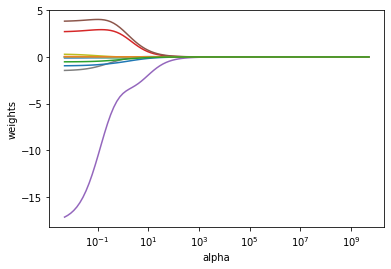

In [52]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

We now split the samples into a training set and a test set in order
to estimate the test error of ridge regression and the lasso:

In [0]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=43)

Next we fit a ridge regression model on the training set, and evaluate
its MSE on the test set, using $\lambda = 4$:

In [54]:
ridge2 = Ridge(alpha = 4, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print("Average MEDV:", np.mean(y_test))
print("MAE:",mean_absolute_error(y_test, pred2))          # Calculate the test MAE
print("MSE:",mean_squared_error(y_test, pred2))          # Calculate the test MSE
print("MAPE:",mean_absolute_percentage_error(y_test,pred2),"%") # Calculate the test MAPE
print("R2Score:",r2_score(y_test, pred2))          # Calculate the test R2

CRIM      -0.039768
ZN         0.012939
INDUS     -0.059757
CHAS       1.148775
NOX       -3.358405
RM         1.332710
AGE       -0.010687
DIS        0.017108
RAD       -0.030200
TAX       -0.002455
PTRATIO   -0.278175
B          0.004021
LSTAT     -0.133982
dtype: float64
Average MEDV: 22.269565217391285
MAE: 4.731888998766052
MSE: 47.509209244430565
MAPE: 25.04109918991282 %
R2Score: 0.43576279211905544


The test MSE when alpha = 4 is 106216. Now let's see what happens if we use a huge value of alpha, say $10^{10}$:

In [55]:
from sklearn.metrics import r2_score
ridge3 = Ridge(alpha = 10**10, normalize = True)
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
#print(pd.Series(ridge3.coef_, index = X.columns)) # Print coefficients

print("Average MEDV:", np.mean(y_test))
print("MAE:",mean_absolute_error(y_test, pred3))          # Calculate the test MAE
print("MSE:",mean_squared_error(y_test, pred3))          # Calculate the test MSE
print("MAPE:",mean_absolute_percentage_error(y_test,pred3),"%") # Calculate the test MAPE
print("R2Score:",r2_score(y_test, pred3))          # Calculate the test R2

Average Salary: 22.269565217391285
MAE: 6.563348901991128
MSE: 84.47795680419348
MAPE: 38.565834433295635 %
R2Score: -0.003291935032005311


This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept. This over-shrinking makes the model more biased, resulting in a higher MSE.

Okay, so fitting a ridge regression model with alpha = 4 leads to a much lower test
MSE than fitting a model with just an intercept. We now check whether
there is any benefit to performing ridge regression with alpha = 4 instead of
just performing least squares regression. Recall that least squares is simply
ridge regression with alpha = 0.

In [56]:
ridge2 = Ridge(alpha = 0, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge2.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print("Average MEDV:", np.mean(y_test))
print("MAE:",mean_absolute_error(y_test, pred))          # Calculate the test MAE
print("MSE:",mean_squared_error(y_test, pred))          # Calculate the test MSE
print("MAPE:",mean_absolute_percentage_error(y_test,pred),"%") # Calculate the test MAPE
print("R2Score:",r2_score(y_test, pred))          # Calculate the test R2

CRIM       -0.022225
ZN          0.029062
INDUS       0.055297
CHAS        1.649471
NOX       -18.443433
RM          3.470573
AGE         0.015169
DIS        -1.126127
RAD         0.313823
TAX        -0.014110
PTRATIO    -1.117602
B           0.010337
LSTAT      -0.619982
dtype: float64
Average MEDV: 22.269565217391285
MAE: 3.413498080266388
MSE: 25.014993629253635
MAPE: 17.63952544624934 %
R2Score: 0.7029125429574625


It looks like we are indeed improving over regular least-squares!

Instead of arbitrarily choosing alpha $ = 4$, it would be better to
use cross-validation to choose the tuning parameter alpha. We can do this using
the cross-validated ridge regression function, `RidgeCV()`. By default, the function
performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the
argument `cv`.

In [57]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

pred11 = ridgecv.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print("Average MEDV:", np.mean(y_test))
print("MAE:",mean_absolute_error(y_test, pred11))          # Calculate the test MAE
print("MSE:",mean_squared_error(y_test, pred11))          # Calculate the test MSE
print("MAPE:",mean_absolute_percentage_error(y_test,pred11),"%") # Calculate the test MAPE
print("R2Score:",r2_score(y_test, pred11))          # Calculate the test R2
ridgecv.alpha_

CRIM       -0.022225
ZN          0.029062
INDUS       0.055297
CHAS        1.649471
NOX       -18.443433
RM          3.470573
AGE         0.015169
DIS        -1.126127
RAD         0.313823
TAX        -0.014110
PTRATIO    -1.117602
B           0.010337
LSTAT      -0.619982
dtype: float64
Average MEDV: 22.269565217391285
MAE: 3.339791843177254
MSE: 24.87083260458118
MAPE: 17.183654393188114 %
R2Score: 0.7046246534164675


0.03527401155359316

Therefore, we see that the value of alpha that results in the smallest cross-validation
error is 0.57. What is the test MSE associated with this value of
alpha?

In [72]:
ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge4.fit(X_train, y_train)
pred4 = ridge4.predict(X_test)
mean_squared_error(y_test, ridge4.predict(X_test))

print("Ridgecv alpha: ", ridgecv.alpha_)

Ridgecv alpha:  0.03527401155359316


This represents a further improvement over the test MSE that we got using
alpha $ = 4$. Finally, we refit our ridge regression model on the full data set,
using the value of alpha chosen by cross-validation, and examine the coefficient
estimates.

In [59]:
ridge4.fit(X, y)
pd.Series(ridge4.coef_, index = X.columns)

CRIM       -0.095410
ZN          0.037889
INDUS      -0.019015
CHAS        2.837895
NOX       -14.350346
RM          3.955089
AGE        -0.002164
DIS        -1.278671
RAD         0.207283
TAX        -0.007828
PTRATIO    -0.897622
B           0.009215
LSTAT      -0.496485
dtype: float64

As expected, none of the coefficients are exactly zero - ridge regression does not
perform variable selection!

# 6.6.2 The Lasso
We saw that ridge regression with a wise choice of alpha can outperform least
squares as well as the null model on the Hitters data set. We now ask
whether the lasso can yield either a more accurate or a more interpretable
model than ridge regression. In order to fit a lasso model, we'll
use the `Lasso()` function; however, this time we'll need to include the argument `max_iter = 10000`.
Other than that change, we proceed just as we did in fitting a ridge model:

Text(0, 0.5, 'weights')

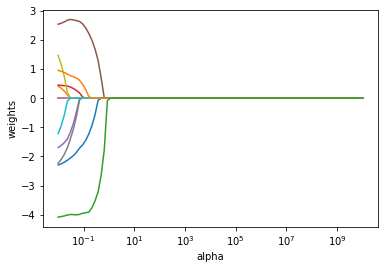

In [60]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

Notice that in the coefficient plot that depending on the choice of tuning
parameter, some of the coefficients are exactly equal to zero. We now
perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [61]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))
pred7=lasso.predict(X_test)
print("Average MEDV:", np.mean(y_test))
print("MAE:",mean_absolute_error(y_test, pred7))          # Calculate the test MAE
print("MSE:",mean_squared_error(y_test, pred7))          # Calculate the test MSE
print("MAPE:",mean_absolute_percentage_error(y_test,pred7),"%") # Calculate the test MAPE
print("R2Score:",r2_score(y_test, pred7))          # Calculate the test R2

Average Salary: 22.269565217391285
MAE: 3.3856253038511945
MSE: 25.164468239278857
MAPE: 17.54168565549317 %
R2Score: 0.701137326363648


This is substantially lower than the test set MSE of the null model and of
least squares, and only a little worse than the test MSE of ridge regression with alpha
chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in
that the resulting coefficient estimates are sparse. Here we see that 1 of
the 13 coefficient estimates is exactly zero:

In [62]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

CRIM       -0.003053
ZN          0.021100
INDUS       0.000000
CHAS        1.715723
NOX       -15.476863
RM          3.574306
AGE         0.005914
DIS        -1.096350
RAD         0.219344
TAX        -0.009535
PTRATIO    -1.064630
B           0.010236
LSTAT      -0.604650
dtype: float64

In [63]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

elas = ElasticNet(alpha=0.01)
elascv = ElasticNetCV(cv=10, random_state=0)
elascv.fit(X_train, y_train)

elas.set_params(alpha=elascv.alpha_,l1_ratio=elascv.l1_ratio)
elas.fit(X_train, y_train)

pred10=elas.predict(X_test)
print("Average MEDV:", np.mean(y_test))
print("MAE:",mean_absolute_error(y_test, pred10))          # Calculate the test MAE
print("MSE:",mean_squared_error(y_test, pred10))          # Calculate the test MSE
print("MAPE:",mean_absolute_percentage_error(y_test,pred10),"%") # Calculate the test MAPE
print("R2Score:",r2_score(y_test, pred10))          # Calculate the test R2
elascv.l1_ratio

Average MEDV: 22.269565217391285
MAE: 3.9002310943646368
MSE: 32.31818711225778
MAPE: 19.520571486984192 %
R2Score: 0.6161770749292794


0.5

In [64]:
from sklearn.feature_selection import SelectFromModel
sel_model = SelectFromModel(lassocv, prefit=True)
sel_model.get_support()

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [65]:
selected_feat = X_train.columns[(sel_model.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))


total features: 13
selected features: 12


In [66]:
X_train_selected = sel_model.transform(X_train.fillna(0))
X_test_selected = sel_model.transform(X_test.fillna(0))
X_train_selected.shape, X_test_selected.shape

((253, 12), (253, 12))

In [67]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train_selected, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train_selected, y_train)
pred8=lasso.predict(X_test_selected)
print("Average MEDV:", np.mean(y_test))
print("MAE:",mean_absolute_error(y_test, pred8))          # Calculate the test MAE
print("MSE:",mean_squared_error(y_test, pred8))          # Calculate the test MSE
print("MAPE:",mean_absolute_percentage_error(y_test,pred8),"%") # Calculate the test MAPE
print("R2Score:",r2_score(y_test, pred8))          # Calculate the test R2

Average Salary: 22.269565217391285
MAE: 3.390589940836995
MSE: 25.054927673104892
MAPE: 17.535381596546742 %
R2Score: 0.7024382712581358


In [68]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train_selected, y_train)

ridge.set_params(alpha=ridgecv.alpha_)
ridge.fit(X_train_selected, y_train)
pred9=ridge.predict(X_test_selected)
print("Average MEDV:", np.mean(y_test))
print("MAE:",mean_absolute_error(y_test, pred9))          # Calculate the test MAE
print("MSE:",mean_squared_error(y_test, pred9))          # Calculate the test MSE
print("MAPE:",mean_absolute_percentage_error(y_test,pred9),"%") # Calculate the test MAPE
print("R2Score:",r2_score(y_test, pred9))          # Calculate the test R2

Average Salary: 22.269565217391285
MAE: 3.3397232880609535
MSE: 24.870908184212542
MAPE: 17.18318721151003 %
R2Score: 0.7046237558043866


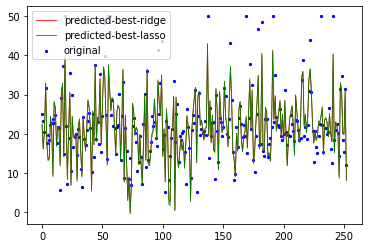

In [69]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, pred11, lw=0.8, color="red", label="predicted-best-ridge")
plt.plot(x_ax, pred8, lw=0.8, color="green", label="predicted-best-lasso")
plt.legend()
plt.show()

Berdasarkan regresi Lasso, terdapat fitur yang dapat dihilangkan, yaitu INDUS. Fitur ini dapat dihilangkan karena koefisien estimasinya bernilai nol.

In [0]:
Berdasarkan regresi Lasso, terdapat fitur yang dapat dihilangkan, yaitu INDUS. Fitur ini dapat dihilangkan